In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys

from pyoperators import MPI

from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Instrument.Qacquisition import QubicMultiAcquisitions
from qubic.lib.Qsamplings import get_pointing, equ2gal
from qubic.lib.QskySim import Qubic_sky
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel

[mac.home:04172] shmem: mmap: an error occurred while determining whether or not /var/folders/w9/8m01n1pn32sfhxknqn_bm6dr0000gp/T//ompi.mac.502/jf.0/4148297728/sm_segment.mac.502.f7420000.0 could be created.


In [3]:
%matplotlib inline

In [4]:
nside = 256

# Initialize QUBIC instance

Build the QUBIC dictionary, mandatory to use the QUBIC functions

In [5]:
def get_dict():
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": 30,
        "nf_recon": 2,
        "nf_sub": 10,
        "nside": nside,
        "MultiBand": True,
        "period": 1,
        "RA_center": 0,
        "DEC_center": -57,
        "filter_nu": 150 * 1e9,
        "noiseless": True,
        # "comm": comm,
        "dtheta": 15,
        # "nprocs_sampling": 1,
        # "nprocs_instrument": comm.Get_size(),
        "photon_noise": False,
        "nhwp_angles": 3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(4.7e-17),
        "synthbeam_kmax": 1,
        "synthbeam_fraction": 1,
        "beam_shape": "gaussian",
        "debug":False,
        "kind": "IQU",
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic

In [6]:
# Build MPI communicator and qubic dict
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d = qubicDict()
d.read_from_file(dictfilename)

d = get_dict()

center = equ2gal(d['RA_center'], d['DEC_center'])

d['nf_recon'] = 2
d['MultiBand'] = True
d['nside'] = nside

npointings = 30
d['npointings'] = npointings
d['synthbeam_kmax'] = 1
nf_sub = d['nf_sub']
d['synthbeam_fraction'] = 1

d['noiseless'] = True
d['photon_noise'] = False
d['use_synthbeam_fits_file'] = False

input_comm = True
if input_comm:

    comm = MPI.COMM_WORLD
    d["comm"] = comm
    d["nprocs_sampling"] = comm.Get_size()
    d["nprocs_instrument"] = 1
    print("comm.Get_size()", comm.Get_size())
    nprocs_instrument = d['nprocs_instrument']
    nprocs_sampling = d['nprocs_sampling']
    comm = d['comm']

    print("nprocs_instrument", nprocs_instrument)
    print("nprocs_sampling", nprocs_sampling)
    print("comm", comm)


comm.Get_size() 1
nprocs_instrument 1
nprocs_sampling 1
comm <mpi4py.MPI.Intracomm object at 0x12101a940>


In [7]:
d

{'debug': False,
 'config': 'FI',
 'filter_nu': 150000000000.0,
 'filter_relative_bandwidth': 0.25,
 'beam_shape': 'gaussian',
 'MultiBand': True,
 'nf_sub': 10,
 'center_detector': False,
 'psd': None,
 'bandwidth': None,
 'twosided': None,
 'sigma': None,
 'detector_nep': 4.7e-17,
 'detector_fknee': 0,
 'detector_fslope': 1,
 'detector_ncorr': 10,
 'detector_ngrids': 1,
 'detector_tau': 0.01,
 'polarizer': True,
 'synthbeam_fraction': 1,
 'synthbeam_kmax': 1,
 'synthbeam_peak150_fwhm': 0.39268176,
 'ripples': False,
 'nripples': 0,
 'focal_length': 0.3,
 'optics': 'CalQubic_Optics_v3_CC_FFF.txt',
 'primbeam': 'CalQubic_PrimBeam_v2.fits',
 'detarray': 'CalQubic_DetArray_v4_CC.fits',
 'hornarray': 'CalQubic_HornArray_CC.fits',
 'synthbeam': 'CalQubic_Synthbeam_Analytical_220_FI.fits',
 'nside': 256,
 'kind': 'IQU',
 'absolute': False,
 'temperature': 2.7255,
 'summer': False,
 'RA_center': 0,
 'DEC_center': -57,
 'period': 1,
 'date_obs': '2016-01-01 00:00:00',
 'latitude': -24.1833333

In [8]:
# Build scanning strategy
sampling = get_pointing(d)

In [9]:
# Number of sub-acquisitions
# nsub_max = 42
# nsub_list = np.arange(4, nsub_max + 1, 4)
nsub_max = 64 #104 #64 #84
step = 20
nsub_list = np.arange(4, nsub_max + step, step)
# step_small = 4
# nsub_list = np.concatenate((np.arange(4, 40 + step_small, step_small), np.arange(24 + step, nsub_max + step, step)))

In [10]:
def thetaphi2lonlat(theta, phi):
    """Transform co-latitude and longitude (rad) into longitude and latitude (deg)

    Parameters
    ----------
    theta : int or array-like
    Co-latitude in radians
    phi : int or array-like
    Longitude in radians

    Returns
    -------
    lon, lat : float, scalar or array-like
    The longitude and latitude in degrees
    """
    return np.degrees(phi), 90.0 - np.degrees(theta)

In [11]:
bilinear_interp = True
d["interp_projection"] = bilinear_interp # update the dictionnary

only_P = False

use_Stokes = "IQU" # "I", "QU", "IQU", "no"
list_Stokes = ["I", "Q", "U"]

flat_I = True

convolution_in = False # cannot be put to True in this code! (not implemented in master)
# d["convolution_in"] = convolution_in

TOD_list = []
freq_list = []
TOD_all = []

np.random.seed(d['seed'])

# Build CMB map
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
cmb_map = hp.synfast(cl_cmb, nside, new=True, verbose=False).T

input_maps = cmb_map
for iStoke, Stoke in enumerate(list_Stokes):
    if Stoke not in use_Stokes:
        print("Removing {}...".format(Stoke))
        input_maps[:, iStoke] = 0

if flat_I:
    print("Setting I to ones...")
    input_maps[:, 0] = np.ones_like(input_maps[:, 0])

nrec = 2
for insub in nsub_list:

    # Build acquisition operator
    Qacq = QubicMultiAcquisitions(d, insub, nrec, sampling=sampling)

    # Build TOD
    tod = []
    map_list = []
    print(np.shape(Qacq.H))
    keep_all = []
    if only_P:
        all_P = []
    for i in range(insub):
        if only_P == False:
            tod.append(Qacq.H[i](input_maps))
        else:
            if bilinear_interp:
                P = Qacq.subacqs[i].instrument.get_projection_operator(Qacq.subacqs[i].sampling, Qacq.subacqs[i].scene, verbose=False, bricolage=True)
                tod.append(P(input_maps))
            else:
                P = Qacq.subacqs[i].instrument.get_projection_operator(Qacq.subacqs[i].sampling, Qacq.subacqs[i].scene, verbose=False, bricolage=False)
                tod.append(P(input_maps))
    TOD_list.append(np.sum(tod, axis=0))
    TOD_all.append(tod)
    freq_list.append(np.array(Qacq.allnus))
    # sys.exit()


Removing Q...
Removing U...
executing: self.detarray = '/Users/huchet/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/Users/huchet/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/Users/huchet/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/Users/huchet/qubic/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/Users/huchet/qubic/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/Users/huchet/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/Users/huchet/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/Users/huchet/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/Users/huchet/qubic/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/Users/huchet/qubic/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray

In [12]:
test_tod = np.sum(TOD_all[0], axis=-1)
print(np.shape(test_tod))

(4, 992)


In [13]:
np.shape(TOD_all[0])

(4, 992, 30)

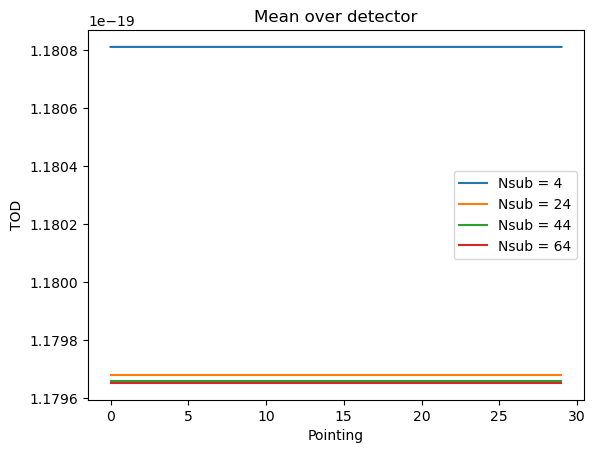

In [14]:
for i in range(nsub_list.size):
    plt.plot(np.mean(TOD_list[i], axis=0), label=f"Nsub = {nsub_list[i]}")

plt.title("Mean over detector")
plt.xlabel("Pointing")
plt.ylabel("TOD")
plt.legend(loc='best')

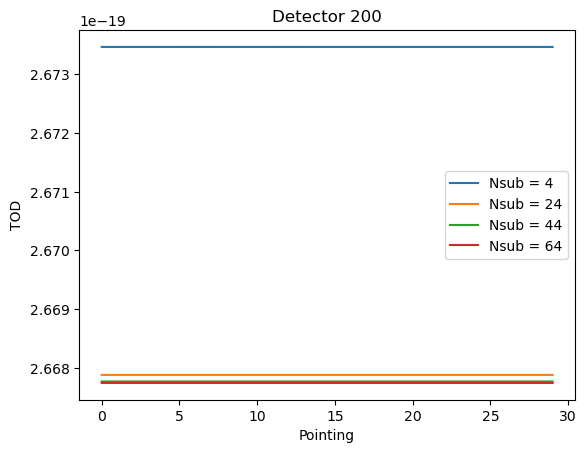

In [15]:
det_index = 200

for i in range(nsub_list.size):
    plt.plot(TOD_list[i][det_index], label=f"Nsub = {nsub_list[i]}")

plt.title(f"Detector {det_index}")
plt.xlabel("Pointing")
plt.ylabel("TOD")
plt.legend(loc='best')

FileNotFoundError: [Errno 2] No such file or directory: 'figures/bilinear_interpolation/nside256_convergence_H_IStokes_30pts_nsub64_bilin.png'

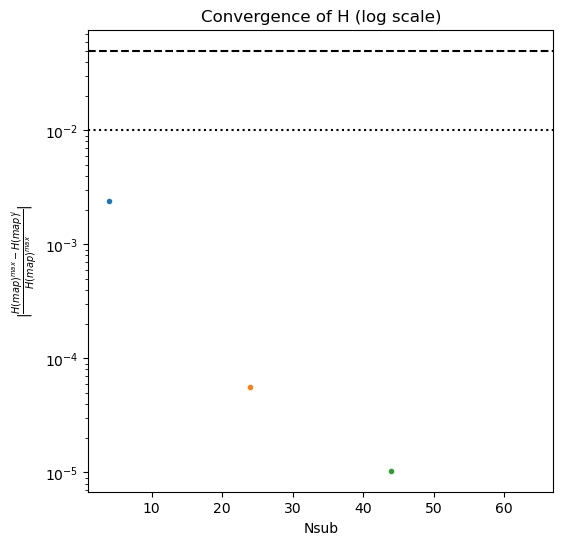

In [16]:
# %%script echo skipping
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(len(TOD_list)):
    rel_error = np.mean(np.abs((TOD_list[i] - TOD_list[-1]) / TOD_list[-1]))
    ax.plot(nsub_list[i], rel_error, '.')

ax.axhline(y=0.05, ls="--", c="k")
ax.axhline(y=0.01, ls="dotted", c="k")

ax.set_xlabel('Nsub')
ax.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
ax.set_title('Convergence of H (log scale)')
ax.set_yscale('log')
add_info = ""
if bilinear_interp:
    add_info += "_bilin"
if convolution_in:
    add_info += "_convolved"
file_path = "figures/bilinear_interpolation/nside{}_convergence_H_{}Stokes_{}pts_nsub{}{}.png".format(nside, use_Stokes, npointings, nsub_max, add_info)
plt.savefig(file_path, dpi=200)
print("Saved plot as {}".format(file_path))

In [24]:
print(np.shape(TOD_all[1]))
print(np.shape(freq_list[0]))

(24, 992, 30)
(4,)


In [25]:
print(len(nsub_list))
print(len(TOD_all))

6
6


10


FileNotFoundError: [Errno 2] No such file or directory: 'figures/bilinear_interpolation/nside256_onepointing_H_IStokes_nsub64_bilin.png'

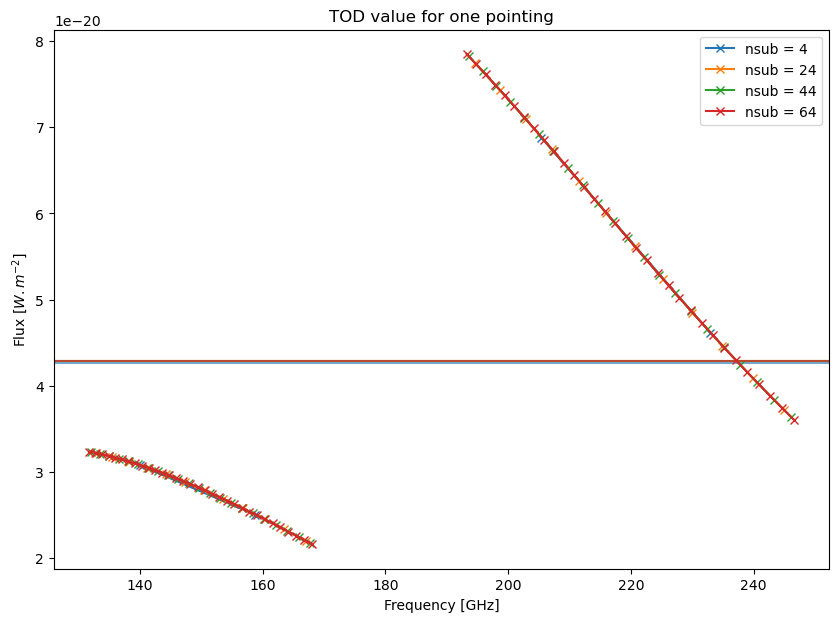

In [17]:
idet = 0
ipoint = 0
array_colors = [p["color"] for p in plt.rcParams["axes.prop_cycle"]] #plt.rcParams["axes.prop_cycle"]
print(len(array_colors))
plt.figure(figsize=(10, 7))
for i in range(len(TOD_all)):
    nsub_i = len(TOD_all[i])
    # if nsub_i not in [36, 40, 104]: # to plot only some nsub
    #     continue
    if only_P:
        plot_yi = np.array([ TOD_all[i][j][idet][ipoint][2] for j in range(nsub_i) ]) # here we just take I for now because I set Q and U to zero
    else:
        plot_yi = np.array([ TOD_all[i][j][idet][ipoint] for j in range(nsub_i) ]) * nsub_i
    plot_xi = freq_list[i]
    # plt.plot(plot_xi, plot_yi*nsub_i, ".", label="nsub = {}".format(nsub_i))
    plt.plot(plot_xi[:nsub_i//2], plot_yi[:nsub_i//2], "x-", c=array_colors[i%len(array_colors)], label="nsub = {}".format(nsub_i))
    plt.plot(plot_xi[nsub_i//2:], plot_yi[nsub_i//2:], "x-", c=array_colors[i%len(array_colors)])
    plt.axhline(np.sum(plot_yi)/nsub_i, c=array_colors[i%len(array_colors)], alpha=1/(len(nsub_list)*2 - i) + 0.5)
    plt.title("TOD value for one pointing")
    plt.xlabel("Frequency [GHz]")
    plt.ylabel(r"Flux [$W.m^{-2}$]")
# plt.yscale("log")
plt.legend()
file_path = "figures/bilinear_interpolation/nside{}_onepointing_H_{}Stokes_nsub{}{}.png".format(nside, use_Stokes, nsub_max, add_info)
plt.savefig(file_path, dpi=300)
print("saved plot as {}".format(file_path))
plt.show()